#Data Gathering

##Data Preparation

In [ ]:
haar = cv2.CascadeClassifier('/content/drive/MyDrive/My/MSc/Research/Face Predictions/haarcascade_frontalface_default.xml')

def crop(image):
  global haar
  gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  face_cordinates = haar.detectMultiScale(gray_image,1.5,5)
  crop_images = []
  for x,y,w,h in face_cordinates:
    roi = gray_image[y:y+h,x:x+w]
    crop_images.append(roi)
  return crop_images , face_cordinates


def _save_croped_image(image_path,save_path,gender,i,image_size):
  image = cv2.imread(image_path)
  crop_images , face_cordinates = crop(image)
  for im in crop_images:
    if im.shape[0] >= 48:  # Minimum size of acceptable image is 48
      im = cv2.resize(im,(image_size,image_size),cv2.INTER_AREA) # Shrink image to 48 x 48
      cv2.imwrite(f'{save_path}/{gender}/{gender}_{i}.png', im)
    else:
      print(f'{gender} Path {i} SMALLER than 48 x 48')

In [ ]:
female_paths = glob('/content/drive/MyDrive/My/MSc/Research/Face Predictions/Gender/Original/female/*.jpg')
male_paths = glob('/content/drive/MyDrive/My/MSc/Research/Face Predictions/Gender/Original/male/*.jpg')
save_path = '/content/drive/MyDrive/My/MSc/Research/Face Predictions/Gender/Crop'
image_size = 48

for i,image_path in enumerate(female_paths):
    try:
        _save_croped_image(image_path,save_path,'female',i,image_size)
        #print(f'Female Path {i} Successful')
    except:
        print(f'Female Path {i} NOT Successful. Error Occured !!!')

for i,image_path in enumerate(male_paths):
    try:
        _save_croped_image(image_path,save_path,'male',i,image_size)
        #print(f'Male Path {i} Successful')
    except:
        print(f'Male Path {i} NOT Successful. Error Occured !!!')

male Path 474 SMALLER than 48 x 48
male Path 1788 SMALLER than 48 x 48


##Gender Model

###Image Generators

In [ ]:
batch_size = 64
train_size = 12000 # Change to 12000
vali_size = 5000 # Change to 5840

train_path = '/content/drive/MyDrive/My/MSc/Research/Face Predictions/Gender/Data/Train'
test_path = '/content/drive/MyDrive/My/MSc/Research/Face Predictions/Gender/Data/Test'
vali_path = '/content/drive/MyDrive/My/MSc/Research/Face Predictions/Gender/Data/Validation'

model_gen_ph1_path = '/content/drive/MyDrive/My/MSc/Research/Face Predictions/Gender/Models/model_gen_ph1.h5'
model_gen_final_path = '/content/drive/MyDrive/My/MSc/Research/Face Predictions/Gender/Models/model_gen_final.h5'

image_generator = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.05, # Shift the pic width by a max of 5%
                               height_shift_range=0.05, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.05, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.05, # Zoom in by 5% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest', # Fill in missing pixels with the nearest filled value
                              )

# test_photo = f'{train_path}/female1/female1_100.png'
# para_img = cv2.imread(test_photo)
# fig, axs = plt.subplots(1, 2)
# axs[0].imshow(para_img)
# axs[1].imshow(image_generator.random_transform(para_img))

In [ ]:
train_generator = image_generator.flow_from_directory(train_path,
                                          target_size=(48,48),
                                          color_mode="rgb",
                                          batch_size=batch_size,
                                          class_mode='binary')

print(f'\nClass Lables : {train_generator.class_indices}')

Found 24049 images belonging to 2 classes.

Class Lables : {'female1': 0, 'male1': 1}


In [ ]:
test_generator = image_generator.flow_from_directory(test_path,
                                         target_size=(48,48),
                                         color_mode="rgb",
                                         batch_size=batch_size,
                                         class_mode='binary',
                                         shuffle=False)

print(f'\nClass Lables : {test_generator.class_indices}')

Found 6054 images belonging to 2 classes.

Class Lables : {'female': 0, 'male': 1}


In [ ]:
vali_generator = image_generator.flow_from_directory(vali_path,
                                         target_size=(48,48),
                                         color_mode="rgb",
                                         batch_size=batch_size,
                                         class_mode='binary',
                                         shuffle=False)

print(f'\nClass Lables : {vali_generator.class_indices}')

Found 6054 images belonging to 2 classes.

Class Lables : {'female': 0, 'male': 1}


###Model Training

####Phase 01

In [ ]:
backbone = EfficientNetB2(input_shape=(48, 48, 3), include_top=False)

model_gen = Sequential()
model_gen.add(backbone)
model_gen.add(GlobalAveragePooling2D())
model_gen.add(Dropout(0.25))
model_gen.add(Dense(units=128,activation='relu'))
model_gen.add(Dense(units=1,activation='sigmoid'))

model_gen.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'],# tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
                  )

model_gen.summary()

31801344/31790344 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 2, 2, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               180352    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 7,949,050
Trainable params: 7,881,475
Non-trainable params: 67,575
_________________________________________________________________


In [ ]:
# class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
early_stopping = EarlyStopping(monitor = 'val_loss', verbose = 1, patience = 3)
check_pointer = ModelCheckpoint(filepath = model_gen_ph1_path, verbose = 1, monitor='val_accuracy', mode='max', save_best_only=True)

history = model_gen.fit(train_generator,
                        epochs=10,
                        validation_data=vali_generator,
                        steps_per_epoch = train_size//batch_size,
                        callbacks=[early_stopping, check_pointer],
                        validation_steps = vali_size//batch_size,
                        #class_weight={k:i for (k,i) in enumerate(class_weights)}
                        )

print(f"\nCell Executed on {(datetime.now() + timedelta(hours=5,minutes=30)).strftime('%Y-%m-%d @ %H:%M:%S')}\n")

Epoch 1/10
187/187 [==============================] - 3872s 21s/step - loss: 0.3896 - accuracy: 0.8301 - val_loss: 2.5039 - val_accuracy: 0.2812

Epoch 00001: val_accuracy improved from -inf to 0.28125, saving model to /content/drive/MyDrive/My/MSc/Research/Face Predictions/Gender/Models/model_gen_ph1.h5
Epoch 2/10
187/187 [==============================] - 1487s 8s/step - loss: 0.2146 - accuracy: 0.9182 - val_loss: 3.8516 - val_accuracy: 0.2812

Epoch 00002: val_accuracy did not improve from 0.28125
Epoch 3/10
187/187 [==============================] - 824s 4s/step - loss: 0.1856 - accuracy: 0.9297 - val_loss: 1.3128 - val_accuracy: 0.2835

Epoch 00003: val_accuracy improved from 0.28125 to 0.28345, saving model to /content/drive/MyDrive/My/MSc/Research/Face Predictions/Gender/Models/model_gen_ph1.h5
Epoch 4/10
187/187 [==============================] - 422s 2s/step - loss: 0.1717 - accuracy: 0.9362 - val_loss: 1.0752 - val_accuracy: 0.2963

Epoch 00004: val_accuracy improved from 0.2

####Phase 02

In [ ]:
model_gen = load_model(model_gen_ph1_path)
model_gen.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model_gen.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 2, 2, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               180352    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 7,949,050
Trainable params: 7,881,475
Non-trainable params: 67,575
_________________________________________________________________


In [ ]:
model_gen.layers[0].trainable = False
early_stopping = EarlyStopping(monitor = 'val_loss', verbose = 1, patience = 5)
check_pointer = ModelCheckpoint(filepath = model_gen_final_path, verbose = 1, monitor='val_accuracy', mode='max', save_best_only=True)
model_gen.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 2, 2, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               180352    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 7,949,050
Trainable params: 180,481
Non-trainable params: 7,768,569
_________________________________________________________________


In [ ]:
history = model_gen.fit(train_generator,
                        epochs=30,
                        validation_data=vali_generator,
                        steps_per_epoch = train_size//batch_size,
                        callbacks=[early_stopping, check_pointer],
                        validation_steps = vali_size//batch_size,
                        #class_weight={k:i for (k,i) in enumerate(class_weights)}
                        )

print(f"\nCell Executed on {(datetime.now() + timedelta(hours=5,minutes=30)).strftime('%Y-%m-%d @ %H:%M:%S')}\n")

Epoch 1/30
187/187 [==============================] - 78s 353ms/step - loss: 0.1751 - accuracy: 0.9376 - val_loss: 2.2261 - val_accuracy: 0.7188

Epoch 00001: val_accuracy improved from -inf to 0.71875, saving model to /content/drive/MyDrive/My/MSc/Research/Face Predictions/Gender/Models/model_gen_final.h5
Epoch 2/30
187/187 [==============================] - 61s 326ms/step - loss: 0.1470 - accuracy: 0.9442 - val_loss: 1.3125 - val_accuracy: 0.2935

Epoch 00002: val_accuracy did not improve from 0.71875
Epoch 3/30
187/187 [==============================] - 61s 326ms/step - loss: 0.1242 - accuracy: 0.9561 - val_loss: 1.8993 - val_accuracy: 0.2817

Epoch 00003: val_accuracy did not improve from 0.71875
Epoch 4/30
187/187 [==============================] - 61s 326ms/step - loss: 0.1174 - accuracy: 0.9593 - val_loss: 1.9180 - val_accuracy: 0.5479

Epoch 00004: val_accuracy did not improve from 0.71875
Epoch 5/30
187/187 [==============================] - 60s 320ms/step - loss: 0.1154 - acc

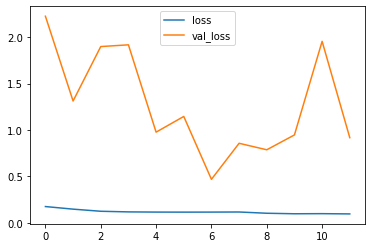

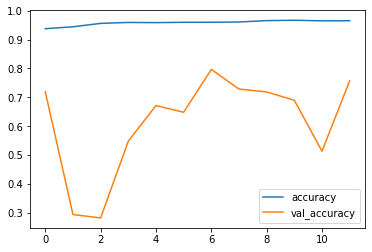

In [ ]:
losses = pd.DataFrame(history.history)
losses[['loss','val_loss']].plot()
losses[['accuracy','val_accuracy']].plot()

####Evaluation

In [ ]:
model_gen = load_model(model_gen_final_path)
model_gen.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 2, 2, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               180352    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 7,949,050
Trainable params: 7,881,475
Non-trainable params: 67,575
_________________________________________________________________


In [ ]:
print(f'Model Matrices For Evaluation : {model_gen.metrics_names}\n')
model_gen.evaluate(test_generator,verbose=1)

95/95 [==============================] - 196s 2s/step - loss: 0.4432 - accuracy: 0.8133


[0.4431906044483185, 0.8133465647697449]

In [ ]:
pred_probabilities = model_gen.predict(test_generator,verbose=1)
predictions = pred_probabilities > 0.5

print(classification_report(test_generator.classes,predictions))

95/95 [==============================] - 21s 196ms/step
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      3588
           1       0.71      0.92      0.80      2466

    accuracy                           0.82      6054
   macro avg       0.82      0.83      0.81      6054
weighted avg       0.84      0.82      0.82      6054



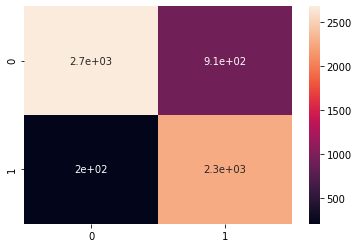

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(test_generator.classes,predictions),annot=True)

#Predict Gender

##Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from datetime import datetime, timedelta
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Activation
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.models import Sequential, load_model, save_model
from sklearn.metrics import classification_report,confusion_matrix

import warnings
warnings.filterwarnings('ignore')

print(f"\nCell Executed on {(datetime.now() + timedelta(hours=5,minutes=30)).strftime('%Y-%m-%d @ %H:%M:%S')}\n")


Cell Executed on 2021-09-18 @ 15:54:45



##Load Model

###Predict Many Images

In [ ]:
#unseen_data_path = '/content/drive/MyDrive/My/MSc/Research/Face Predictions/Gender/Data/Unseen'
unseen_data_path = '/content/drive/MyDrive/My/MSc/Research/Face Predictions/Gender/Data/Evaluate'
model_gen_final_path = '/content/drive/MyDrive/My/MSc/Research/Face Predictions/Gender/Models/model_gen_final.h5'
model_gen = load_model(model_gen_final_path)
model_gen.summary()
print('\n\n-----------Model Outputs-----------\n\n00 --> Female\n01 --> Male')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 2, 2, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               180352    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 7,949,050
Trainable params: 7,881,475
Non-trainable params: 67,575
_________________________________________________________________


-----------Model Outputs-----------

00 --> Female
01 --> Male


In [ ]:
# Credits: https://stackoverflow.com/questions/45806669/how-to-use-predict-generator-with-imagedatagenerator

image_generator_for_predict = ImageDataGenerator(rescale=1 / 255) # We trained for rescaled images.So scaling is must.
unseen_data_gen = image_generator_for_predict.flow_from_directory(unseen_data_path, target_size=(48,48), color_mode="rgb",
                                                                  batch_size=1, class_mode='binary', shuffle=False)
#shuffle = True --> gives predictions of randomly selected data in dataset. So then we can not use "evaluate" method in generator.

filenames = unseen_data_gen.filenames
nb_samples = len(filenames)

print(f'\nClass Lables : {unseen_data_gen.class_indices}\n\nNumber of Samples to Predict : {nb_samples}')

Found 200 images belonging to 2 classes.

Class Lables : {'female': 0, 'male': 1}

Number of Samples to Predict : 200


In [ ]:
print(f'Model Matrices For Evaluation : {model_gen.metrics_names}\n')
model_gen.evaluate_generator(unseen_data_gen, verbose=1, steps=nb_samples)

Model Matrices For Evaluation : ['loss', 'accuracy']

200/200 [==============================] - 58s 278ms/step - loss: 0.1040 - accuracy: 0.9550


[0.10404467582702637, 0.9549999833106995]

200/200 [==============================] - 6s 21ms/step


-----------Model Outputs-----------

00 --> Female
01 --> Male


              precision    recall  f1-score   support

           0       0.95      0.96      0.96       100
           1       0.96      0.95      0.95       100

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200



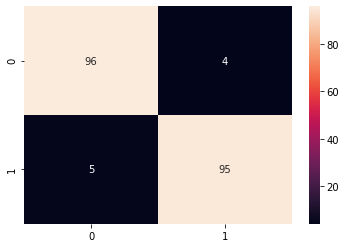

In [ ]:
pred_probabilities = model_gen.predict(unseen_data_gen, verbose=1, steps=nb_samples)
predictions = pred_probabilities > 0.5

print('\n\n-----------Model Outputs-----------\n\n00 --> Female\n01 --> Male\n\n')
print(classification_report(unseen_data_gen.classes,predictions))
sns.heatmap(confusion_matrix(unseen_data_gen.classes,predictions),annot=True)

###Predict Single Image

In [ ]:
model_haar = cv2.CascadeClassifier('/content/drive/MyDrive/My/MSc/Research/Face Predictions/haarcascade_frontalface_default.xml')
model_gen_final_path = '/content/drive/MyDrive/My/MSc/Research/Face Predictions/Gender/Models/model_gen_final.h5'
image_path = '/content/Capture1.PNG'
save_path = '/content/'
model_gen = load_model(model_gen_final_path)
model_gen.summary()
print('\n\n-----------Model Outputs-----------\n\n00 --> Female\n01 --> Male')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 2, 2, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               180352    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 7,949,050
Trainable params: 7,881,475
Non-trainable params: 67,575
_________________________________________________________________


-----------Model Outputs-----------

00 --> Female
01 --> Male


In [ ]:
def final_face_cordinates(gray_image):

  haar_front = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  haar_profile = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_profileface.xml')

  # af1_list = [1.5, 1.3]
  # af2_list = [5,  3]
  # ap1_list = [1.5, 1.3]
  # ap2_list = [5,   3]

  af1_list = [1.5,1.2, 1.3]
  af2_list = [5,2,  3]
  ap1_list = [1.5,1.4, 1.2]
  ap2_list = [5,3,  3]
  face_cordinates = []

  for i in range(len(af1_list)):

    array_front = haar_front.detectMultiScale(gray_image,af1_list[i],af2_list[i])
    array_profile = haar_profile.detectMultiScale(gray_image,ap1_list[i],ap2_list[i])

    if (len(array_front) == 0) and (len(array_profile) > 0): temp_face_cordinates = [list(x) for x in array_profile]
    elif len(array_profile) == 0: temp_face_cordinates = [list(x) for x in array_front]
    else: temp_face_cordinates = [list(x) for x in np.concatenate((array_front, array_profile), axis=0)]
    face_cordinates.extend(temp_face_cordinates)
    #print(af1,af2,ap1,ap2,face_cordinates)

  d_face_cords = {(x,y,w,h):True for x,y,w,h in face_cordinates}
  face_cordinates= [[x,y,w,h] for x,y,w,h in d_face_cords.keys()]
  d_keep = {id:True for id in range(len(face_cordinates))}
  #print(f'Final Face Cords : {face_cordinates}')
  d_xy = {id:(item[0],item[0]+item[2],item[1],item[1]+item[3]) for id,item in enumerate(face_cordinates)}
  for id_keep,item_keep in enumerate(face_cordinates):
    x_lu = item_keep[0] ; y_lu = item_keep[1];
    x_ld = item_keep[0] ; y_ld = item_keep[1] + item_keep[3];
    x_ru = item_keep[0] + item_keep[2] ; y_ru = item_keep[1];
    x_rd = item_keep[0] + item_keep[2] ; y_rd = item_keep[1] + item_keep[3];
    for i in range(len(face_cordinates)):
      x_min = d_xy[i][0]; x_max = d_xy[i][1];
      y_min = d_xy[i][2]; y_max = d_xy[i][3];

      if id_keep==i or not d_keep[i]: continue
      elif (x_min <= x_lu <= x_max) and (y_min <= y_lu <= y_max):
        d_keep[id_keep] = False
        continue
      elif (x_min <= x_ld <= x_max) and (y_min <= y_ld <= y_max):
        d_keep[id_keep] = False
        continue
      elif (x_min <= x_ru <= x_max) and (y_min <= y_ru <= y_max):
        d_keep[id_keep] = False
        continue
      elif (x_min <= x_rd <= x_max) and (y_min <= y_rd <= y_max):
        d_keep[id_keep] = False
        continue

  return [list(face_cordinates[id]) for id in range(len(face_cordinates)) if d_keep[id]]

def Crop_Load(image_path, save_path, model_gen):
  image_upload = cv2.imread(image_path)
  print(image_upload.shape)
  gray_image = cv2.cvtColor(image_upload,cv2.COLOR_BGR2GRAY)
  crop_images = []
  face_cordinates = final_face_cordinates(gray_image)
  #print(f'Crop Fun Face Cords : {face_cordinates}')
  for x,y,w,h in face_cordinates:
    roi = gray_image[y:y+h,x:x+w]
    crop_images.append(roi)

  if len(crop_images)==0:
    print('''Please Upload images that contains Direct Faces.''')
  else:
    # for i in crop_images:
    #     result = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    #     pixels = np.array(result)
    #     plt.imshow(pixels)
    #     plt.show()
    for id,im in enumerate(crop_images):
      if im.shape[0] >= 48:  # Minimum size of acceptable image is 48
        im_48 = cv2.resize(im,(48,48),cv2.INTER_AREA) # Shrink image to 48 x 48
        im_ch3 = cv2.cvtColor(im_48,cv2.COLOR_GRAY2RGB) # Gray image with 3 channels
        im_reshape = im_ch3.reshape(1,48,48,3) # batch_size,height,width,channels
        im_scaled = im_reshape/255  # We trained model for scaled data
        model_pred = round(float(model_gen.predict(im_scaled)[0][0]),3) #python cannot round np.float32

        if model_pred <= 0.30: gender = 'Female'; #print(f'\nPrediction : {gender}  | Probability : {model_pred*100} %\n')
        elif model_pred >=0.70: gender = 'Male'; #print(f'\nPrediction : {gender} |  Probability : {model_pred*100} %\n')
        else: print(f'\nIGNORED : {model_pred}\n'); continue

        x,y,w,h = face_cordinates[id]
        cv2.rectangle(image_upload,(x,y),(x+w,y+h),(0,255,0),2)
        cv2.putText(image_upload, f'{gender}', (x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)


      else:
        print(f'\nSome Faces in Your Image are Too SMALL!!\n')
    cv2.imwrite(f"{save_path}{image_path.split('.')[-2][-2:]}.{image_path.split('.')[-1]}", image_upload)
  return image_upload

for i in range(1,2):
  image_path = f'/content/Edits/Capture{i:02d}.PNG'
  save_path = '/content/Saves/'
  print(f'\n\n========================== IMAGE {i:02d} ==========================\n\n')
  result = Crop_Load(image_path,save_path,model_gen)
  result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
  pixels = np.array(result)
  plt.imshow(pixels)
  plt.show()

In [ ]:
def final_face_cordinates(gray_image):

  haar_front = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  haar_profile = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_profileface.xml')

  af1_list = [1.5, 1.3]
  af2_list = [5,  3]
  ap1_list = [1.5, 1.3]
  ap2_list = [5,   3]
  face_cordinates = []

  for af1 in af1_list:
    for af2 in af2_list:
      for ap1 in ap1_list:
        for ap2 in ap2_list:
          array_front = haar_front.detectMultiScale(gray_image,af1,af2)
          array_profile = haar_profile.detectMultiScale(gray_image,ap1,ap2)

          if (len(array_front) == 0) and (len(array_profile) > 0): temp_face_cordinates = [list(x) for x in array_profile]
          elif len(array_profile) == 0: temp_face_cordinates = [list(x) for x in array_front]
          else: temp_face_cordinates = [list(x) for x in np.concatenate((array_front, array_profile), axis=0)]
          face_cordinates.extend(temp_face_cordinates)
          #print(af1,af2,ap1,ap2,face_cordinates)

  d_face_cords = {(x,y,w,h):True for x,y,w,h in face_cordinates}
  face_cordinates= [[x,y,w,h] for x,y,w,h in d_face_cords.keys()]
  d_keep = {id:True for id in range(len(face_cordinates))}
  #print(f'Final Face Cords : {face_cordinates}')
  d_xy = {id:(item[0],item[0]+item[2],item[1],item[1]+item[3]) for id,item in enumerate(face_cordinates)}
  for id_keep,item_keep in enumerate(face_cordinates):
    x_lu = item_keep[0] ; y_lu = item_keep[1];
    x_ld = item_keep[0] ; y_ld = item_keep[1] + item_keep[3];
    x_ru = item_keep[0] + item_keep[2] ; y_ru = item_keep[1];
    x_rd = item_keep[0] + item_keep[2] ; y_rd = item_keep[1] + item_keep[3];
    for i in range(len(face_cordinates)):
      x_min = d_xy[i][0]; x_max = d_xy[i][1];
      y_min = d_xy[i][2]; y_max = d_xy[i][3];

      if id_keep==i or not d_keep[i]: continue
      elif (x_min <= x_lu <= x_max) and (y_min <= y_lu <= y_max):
        d_keep[id_keep] = False
        continue
      elif (x_min <= x_ld <= x_max) and (y_min <= y_ld <= y_max):
        d_keep[id_keep] = False
        continue
      elif (x_min <= x_ru <= x_max) and (y_min <= y_ru <= y_max):
        d_keep[id_keep] = False
        continue
      elif (x_min <= x_rd <= x_max) and (y_min <= y_rd <= y_max):
        d_keep[id_keep] = False
        continue

  return [list(face_cordinates[id]) for id in range(len(face_cordinates)) if d_keep[id]]

def Crop_Load(image_path, save_path, model_gen):
  image_upload = cv2.imread(image_path)
  gray_image = cv2.cvtColor(image_upload,cv2.COLOR_BGR2GRAY)
  crop_images = []
  face_cordinates = final_face_cordinates(gray_image)
  #print(f'Crop Fun Face Cords : {face_cordinates}')
  for x,y,w,h in face_cordinates:
    roi = gray_image[y:y+h,x:x+w]
    crop_images.append(roi)

  if len(crop_images)==0:
    print('''Please Upload images that contains Direct Faces.''')
  else:
    # for i in crop_images:
    #     result = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    #     pixels = np.array(result)
    #     plt.imshow(pixels)
    #     plt.show()
    for id,im in enumerate(crop_images):
      if im.shape[0] >= 48:  # Minimum size of acceptable image is 48
        im_48 = cv2.resize(im,(48,48),cv2.INTER_AREA) # Shrink image to 48 x 48
        im_ch3 = cv2.cvtColor(im_48,cv2.COLOR_GRAY2RGB) # Gray image with 3 channels
        im_reshape = im_ch3.reshape(1,48,48,3) # batch_size,height,width,channels
        im_scaled = im_reshape/255  # We trained model for scaled data
        model_pred = round(float(model_gen.predict(im_scaled)[0][0]),3) #python cannot round np.float32

        if model_pred <= 0.30: gender = 'Female'; #print(f'\nPrediction : {gender}  | Probability : {model_pred*100} %\n')
        elif model_pred >=0.70: gender = 'Male'; #print(f'\nPrediction : {gender} |  Probability : {model_pred*100} %\n')
        else: print(f'\nIGNORED : {model_pred}\n'); continue

        x,y,w,h = face_cordinates[id]
        cv2.rectangle(image_upload,(x,y),(x+w,y+h),(0,255,0),2)
        cv2.putText(image_upload, f'{gender}', (x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        cv2.imwrite(f"{save_path}{image_path.split('.')[-2][-2:]}.{image_path.split('.')[-1]}", image_upload)

      else:
        print(f'\nSome Faces in Your Image are Too SMALL!!\n')
  return image_upload

for i in range(1,16):
  image_path = f'/content/Edits/Capture{i:02d}.PNG'
  save_path = '/content/Saves/'
  print(f'\n\n========================== IMAGE {i:02d} ==========================\n\n')
  result = Crop_Load(image_path,save_path,model_gen)
  result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
  pixels = np.array(result)
  plt.imshow(pixels)
  plt.show()